### collapse data

In [36]:
import pandas, math
from collections import defaultdict
%matplotlib inline

In [38]:
fg_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.splitPfam.dat'
bg_file = '../data/interim/r1_no_tcga/exac.tidy.eff.dbnsfp.gt.anno.hHack.splitPfam.dat'
df_exac_pre = pandas.read_csv(bg_file, sep='\t')
max_exac_an = max(df_exac_pre['an'].values)

df_fg_pre = pandas.read_csv(fg_file, sep='\t')
max_fg = max([p+2*n for p,n in df_fg_pre[['pos_fam', 'neg_fam']].values])
df_exac = df_exac_pre[df_exac_pre['af_1kg_all'] < .01]
df_fg = df_fg_pre[df_fg_pre['af_1kg_all'] < .01]

# don't forget to add non-var counts
var = 'synonymous_variant'
cols = ['pfam', 'chrom', 'pos']
pfam_to_exac_pos = defaultdict(dict)
for pfam, chrom, pos in list(df_exac[df_exac.eff==var][cols].values):
    pfam_to_exac_pos[pfam][str(chrom) + ':' + str(pos)] = True
pfam_to_fg_pos = defaultdict(dict)
for pfam, chrom, pos in list(df_fg[df_fg.eff==var][cols].values):
    pfam_to_fg_pos[pfam][str(chrom) + ':' + str(pos)] = True

missing_exac_count = []
for pfam in pfam_to_fg_pos:
    if not pfam in pfam_to_exac_pos:
        ls = [pfam, len(pfam_to_fg_pos[pfam])]
        missing_exac_count.append(ls)
    else:
        miss_len = len( set(pfam_to_fg_pos[pfam]) - set(pfam_to_exac_pos[pfam]) )
        ls = [pfam, miss_len]
        missing_exac_count.append(ls)
missing_exac_df = pandas.DataFrame({'pfam':[x[0] for x in missing_exac_count],
                                    'miss_exac':[x[1] for x in missing_exac_count]})        
missing_fg_count = []
for pfam in pfam_to_exac_pos:
    if not pfam in pfam_to_fg_pos:
        ls = [pfam, len(pfam_to_exac_pos[pfam])]
        missing_fg_count.append(ls)
    else:
        miss_len = len( set(pfam_to_exac_pos[pfam]) - set(pfam_to_fg_pos[pfam]) )
        ls = [pfam, miss_len]
        missing_fg_count.append(ls)
missing_fg_df = pandas.DataFrame({'pfam':[x[0] for x in missing_fg_count],
                                  'miss_fg':[x[1] for x in missing_fg_count]})

missing_df = pandas.merge(missing_fg_df, missing_exac_df, on='pfam', how='outer').fillna(0)

#fg_pos = set([chrom + ':' + pos for chrom, pos in df_fg[df_fg.eff==var][cols].values])
#missing_exac_count = len(fg_pos) - len(exac_pos)

cols = ['ac', 'an']
g_exac = df_exac[df_exac.eff==var].groupby('pfam')[cols].sum().reset_index()
#g_exac.head()

fg_cols = ['pos_fam', 'neg_fam']
g_fg = df_fg[df_fg.eff==var].groupby('pfam')[fg_cols].sum().reset_index()
#g_fg.head()

m_pre = pandas.merge(g_fg, g_exac, on='pfam', how='outer').fillna(0)
m = pandas.merge(m_pre, missing_df, on='pfam', how='left')
print(max_exac_an, max_fg)
#m.head()

def calc_fg_neg(row, max_fg):
    return 2*row['neg_fam'] + max_fg*row['miss_fg'] + row['pos_fam']

def calc_bg_neg(row, max_exac):
    return row['an'] + max_exac*row['miss_exac']

m.loc[:, 'fg_tot'] = m.apply(lambda row: calc_fg_neg(row, max_fg), axis=1)
m.loc[:, 'bg_tot'] = m.apply(lambda row: calc_bg_neg(row, max_exac_an), axis=1)
m['fg_frac'] = (1+m['pos_fam']) / m['fg_tot']
m['fg_frac_log'] = m.apply(lambda row: math.log(row['fg_frac'], 2), axis=1)
m['bg_frac'] = (1+m['ac']) / m['bg_tot']
m['bg_frac_log'] = m.apply(lambda row: math.log(row['bg_frac'], 2), axis=1)
m['fg_other'] = m['fg_tot'] - m['pos_fam']
m['bg_other'] = m['bg_tot'] - m['ac']
m.head()

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


106210 17165


,pfam,pos_fam,neg_fam,ac,an,miss_fg,miss_exac,fg_tot,bg_tot,fg_frac,fg_frac_log,bg_frac,bg_frac_log,fg_other,bg_other
0,A1_Propeptide:4,15.0,25620.0,30.0,531032.0,4.0,2.0,119915.0,743452.0,0.000133,-12.871653,0.000042,-14.549684,119900.0,743422.0
1,ANF_receptor:66,2.0,11562.0,363.0,10503612.0,30.0,2.0,538076.0,10716032.0,0.000006,-17.452488,0.000034,-14.845473,538074.0,10715669.0
2,Aldedh:173,4.0,14602.0,36.0,955890.0,3.0,1.0,80703.0,1062100.0,0.000062,-13.978407,0.000035,-14.809035,80699.0,1062064.0
3,Aldedh:177,25.0,36490.0,168.0,3504816.0,10.0,3.0,244655.0,3823446.0,0.000106,-13.199950,0.000044,-14.465563,244630.0,3823278.0
4,Aldedh:178,25.0,36490.0,168.0,3504816.0,10.0,3.0,244655.0,3823446.0,0.000106,-13.199950,0.000044,-14.465563,244630.0,3823278.0


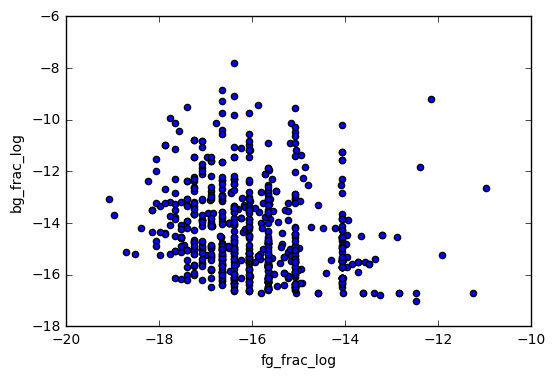

In [39]:
m.plot.scatter('fg_frac_log', 'bg_frac_log')